In [198]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
import shap
import eli5
import os
import functools
import pickle

from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, f1_score ,confusion_matrix, precision_score, plot_precision_recall_curve
import xgboost as xgb
import lightgbm as lgb

plt.style.use('seaborn')

SEED = 1111
in_folds = 1234
out_folds = 4321

### Utilities

In [192]:
def tukey_fences(column, k = 1.5, verbose = True):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    
    kqr = k*(q3-q1)
    lr = q1 - kqr
    hr = q3 + kqr
       
    if isinstance(column, (pd.Series, pd.DataFrame)):
        indices = np.array(column[(column > hr) | (column < lr)].index)
    else:
        indices = np.squeeze(np.where((column > hr) | (column < lr)))
        
    if verbose == True:
        outlier_type = 'Ext. ' if k >= 3 else ''
        print(f'{outlier_type}Outliers outside of range: [{lr:.2f}, {hr:.2f}] | Total {outlier_type}Outliers: {indices.shape[0]}')
        
    return indices

def model_tunner(models, X, y, params, scoring, cv, skip_models = None, verbose = True):
    tunned_models = {}
    
    if not isinstance(models ,dict):
        raise TypeError("Models must be inside dicts")
        
    if isinstance(skip_models, str) or skip_models is None:
        skip_models = [skip_models]
        
    for model in models:
        if model not in params.keys():
            continue
        if model in skip_models:
            continue

        print(f"Total iterations ({model}): " +
              f"{cv.n_splits*functools.reduce(lambda a,b: a*b, [len(params[model][param]) for param in params[model]])}")

        grid = GridSearchCV(models[model], 
                        params[model], 
                        cv = cv,
                        error_score = np.nan,
                        scoring = scoring,
                        n_jobs = 4)

        grid.fit(X,y)
        tunned_models[model] = grid
        if verbose == True:
            print(f"\t{model}\t| Best score: {grid.best_score_:.2f} - {grid.best_params_}")
    return tunned_models

def tune_models(models, tunned_params):
    for model in models:
        if model not in tunned_params:
            pass
        else:
            #print(f"model: {model}\n\t Tunned with: {tunned_params[model].best_params_}")
            models[model].set_params(**tunned_params[model].best_params_)
            
def plot_learning_curve(models, X, y, cv = None, score = None, train_sizes = np.linspace(.1, 1.0, 10), ylim = None, skip_models = None):
    if score is None:
        score = 'accuracy'
        score_name = score
    elif isinstance(score, str):
        score_name = score
    elif callable(score):
        score_name = score.__name__
                        
    if ylim is None:
        ylim_bottom, ylim_top = (0.5, 1.)
    elif isinstance(ylim, (list, tuple)):
        ylim_bottom, ylim_top = ylim
        
    if isinstance(skip_models, str) or skip_models is None:
        skip_models = [skip_models]
        
        
    plt.style.use('ggplot')    
    for n,model in enumerate(models):
        
        if model in skip_models:
            continue
        
        train_sizes, train_scores, test_scores = learning_curve(
                                                    estimator = models[model],
                                                    X = X,
                                                    y = y,
                                                    cv = cv,
                                                    train_sizes = train_sizes,
                                                    scoring = score,
                                                    shuffle = True)
        
        train_scores_mean = np.mean(train_scores, axis = 1)
        train_scores_std = np.std(train_scores, axis = 1)
        test_scores_mean = np.mean(test_scores, axis = 1)
        test_scores_std = np.std(test_scores, axis = 1)
        
        plt.subplot((len(models)//2)+1,2,n+1)
        #train scores std
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha = 0.1, color = 'r')
        #test scores / cross val std
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha = 0.1, color = 'g')
        
        plt.plot(train_sizes, train_scores_mean,
                 'o-', color = 'r',
                 label = f'Training {score} score')
        
        plt.plot(train_sizes, test_scores_mean,
                 'o-', color = 'g',
                 label = f'Cross-val {score} score')
        
        plt.title(f'{model}'.upper())
        plt.xlabel('Training Examples')
        plt.ylabel(score_name)
        plt.ylim(ylim_bottom, ylim_top)
        plt.legend()
        plt.tight_layout()
    return plt

#### Source:
https://www.kaggle.com/mlg-ulb/creditcardfraud
- Transactions made by credit cards in September 2013 by european cardholders.
- Transactions that occurred in two days, 
    - We have 492 frauds out of 284,807 transactions
    
    
- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 
    -  Features V1, V2, … V28 are the principal components obtained with PCA
    - Non PCA: 'Time' and 'Amount'.
        -  'Time' contains the seconds elapsed between each transaction
        -  'Amount' is the transaction Amount

In [60]:
df = pd.read_csv('datasets/creditcard.csv')

In [61]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [62]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [63]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


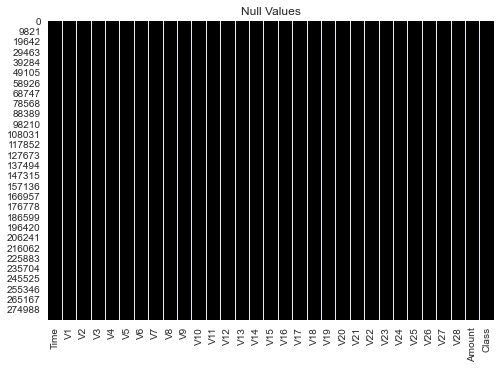

In [64]:
plt.title('Null Values')
sns.heatmap(df.isnull(), cmap = 'gray', cbar = False)
plt.show()

- No Null values were found in the dataset

In [65]:
pd.concat([df.Class.value_counts().to_frame(),100*df.Class.value_counts().to_frame()/df.shape[0]], axis = 1)

,Class,Class
0,284315,99.827251
1,492,0.172749


There's heavy class imbalance.
This means we should:
- undersample dataset
- oversample dataset (not likely as only 0.17% of the data is Fraud)
- Generate artificial data

- Cross Validation will be used to optimize the model

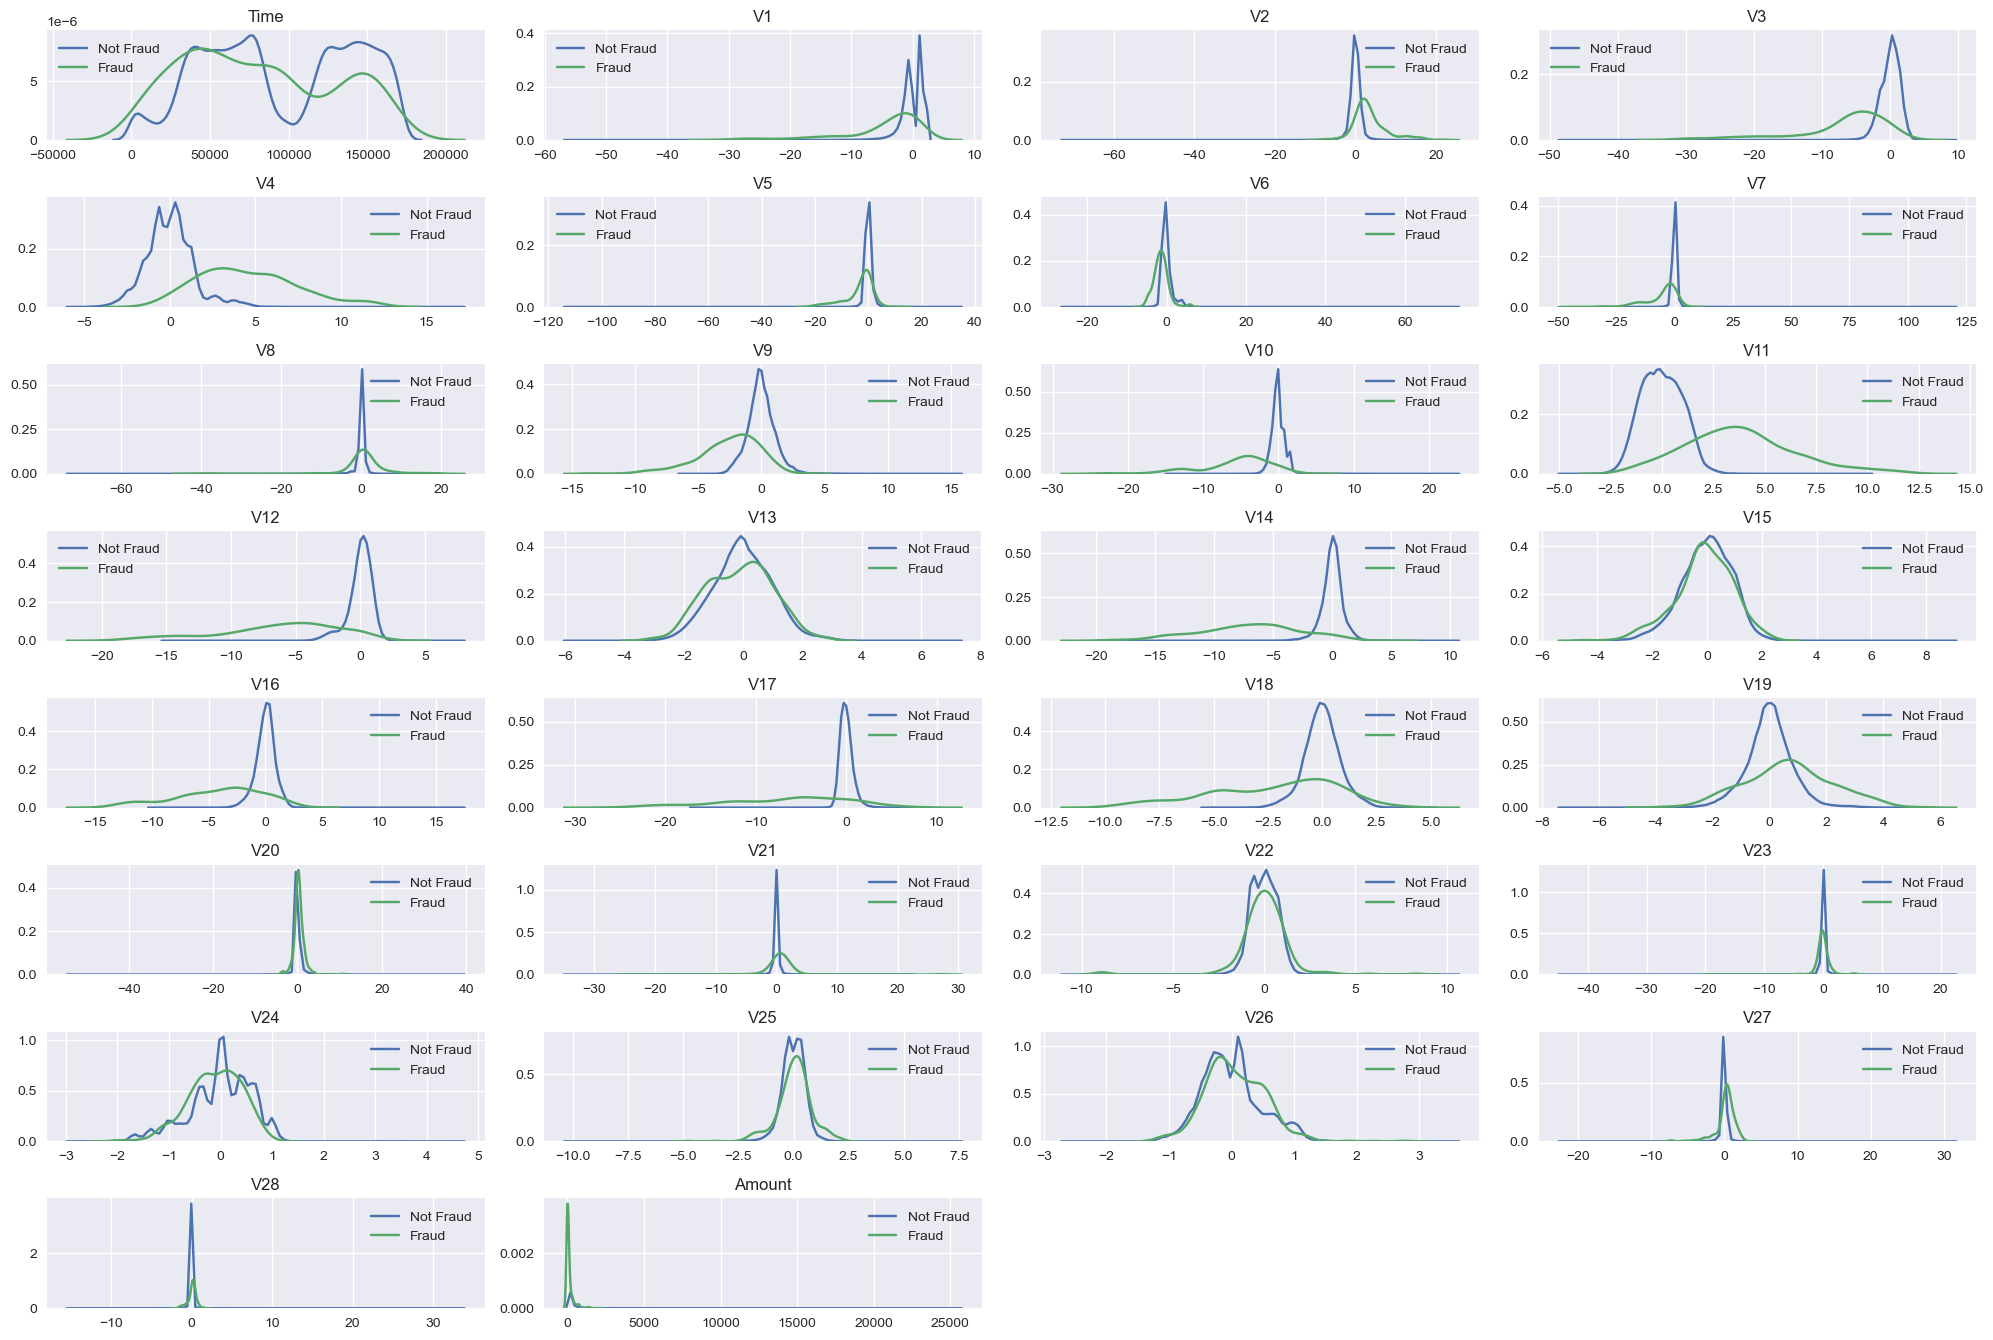

In [66]:
plt.figure(figsize = (20, 50), dpi = 100)
for n, col in enumerate(df.columns[:-1]):
    #if n <= len(columns):
    plt.subplot(df.columns[:-1].shape[0],4,n+1)
    plt.title(col)
    sns.kdeplot(df[df.Class == 0][col], label = 'Not Fraud')
    sns.kdeplot(df[df.Class == 1][col], label = 'Fraud')
plt.tight_layout()
plt.show()

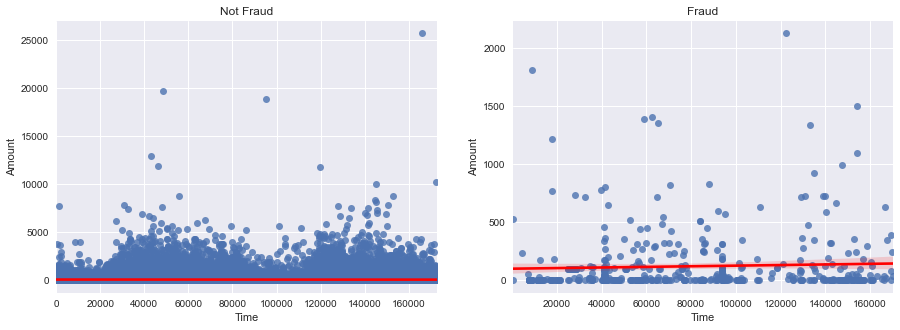

In [67]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.title('Not Fraud')
sns.regplot(x = 'Time', y = 'Amount', data = df[df.Class == 0], line_kws = {'color': 'r'})
plt.subplot(1,2,2)
plt.title('Fraud')
sns.regplot(x = 'Time', y = 'Amount', data = df[df.Class == 1], line_kws = {'color': 'r'})

- Most Fraud transactions are for small amounts of money. 
- There doesn't seem to be any visible relation between fraud and time

Ext. Outliers outside of range: [-209.09, 291.86] | Total Ext. Outliers: 18941
Outliers outside of range: [-101.75, 184.51] | Total Outliers: 31904


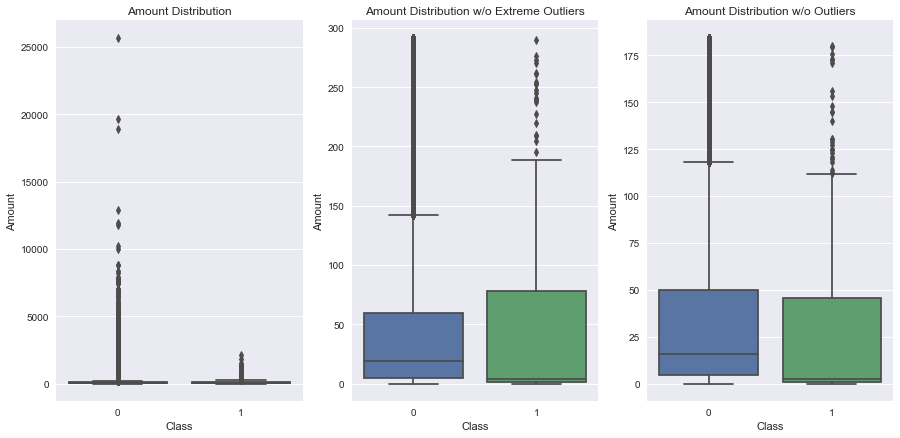

In [68]:
plt.figure(figsize = (15, 7))
plt.subplot(131)
plt.title('Amount Distribution')
sns.boxplot(y = 'Amount', x = 'Class' , data = df)
plt.subplot(132)
plt.title('Amount Distribution w/o Extreme Outliers')
sns.boxplot(y = 'Amount', x = 'Class' , data = df.drop(tukey_fences(df.Amount, k = 3)))
plt.subplot(133)
plt.title('Amount Distribution w/o Outliers')
sns.boxplot(y = 'Amount', x = 'Class' , data = df.drop(tukey_fences(df.Amount, k = 1.5)))
plt.show()

In [69]:
df_extreme_outliers = pd.DataFrame(df.loc[tukey_fences(df.Amount, k = 3, verbose = False)].Class.value_counts())
df_extreme_outliers.index, df_extreme_outliers.columns = ['Not Fraud', 'Fraud'], ['Ext. Outliers']

df_outliers = pd.DataFrame(df.loc[tukey_fences(df.Amount, k = 1.5, verbose = False)].Class.value_counts())
df_outliers.index, df_outliers.columns = ['Not Fraud', 'Fraud'], ['Outliers']

pd.concat([df_extreme_outliers, df_outliers], axis = 1)

,Ext. Outliers,Outliers
Not Fraud,18876,31813
Fraud,65,91


In [70]:
df_nfraud_xt_outliers = pd.DataFrame(df[df.Class == 0].loc[tukey_fences(df[df.Class == 0].Amount, k = 3, verbose = False)].Class.value_counts())
df_nfraud_outliers = pd.DataFrame(df[df.Class == 0].loc[tukey_fences(df[df.Class == 0].Amount, k = 1.5, verbose = False)].Class.value_counts())
pd.concat([df_nfraud_xt_outliers, df_nfraud_outliers], axis = 1)

,Class,Class
0,18910,31862


In [71]:
df_fraud_xt_outliers = pd.DataFrame(df[df.Class == 1].loc[tukey_fences(df[df.Class == 1].Amount, k = 3, verbose = False)].Class.value_counts())
df_fraud_outliers = pd.DataFrame(df[df.Class == 1].loc[tukey_fences(df[df.Class == 1].Amount, k = 1.5, verbose = False)].Class.value_counts())
pd.concat([df_fraud_xt_outliers, df_fraud_outliers], axis = 1)

,Class,Class
1,42,69


### First view at correlations

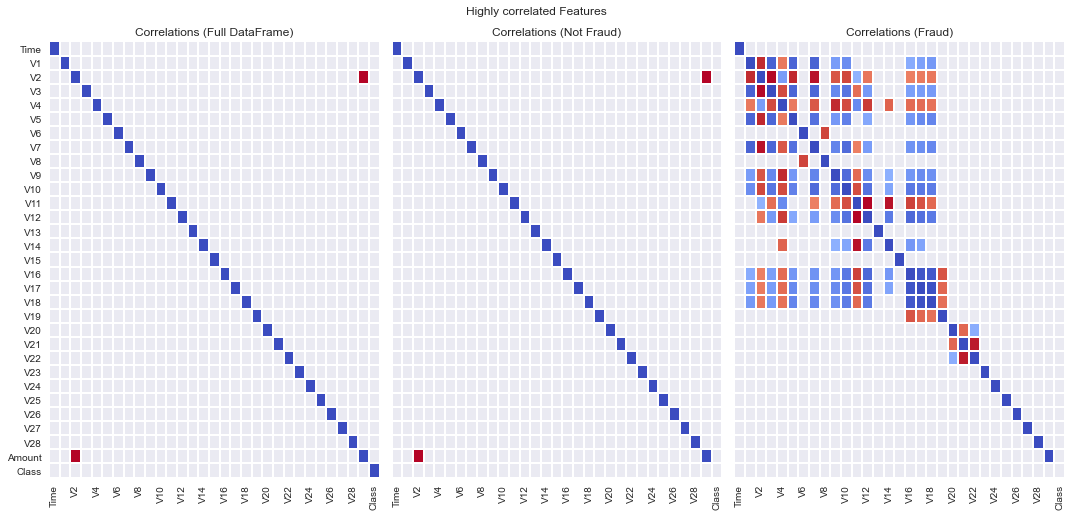

In [72]:
def corr_plot_info(df, threshold = 0.5, plot = True): 
    
    global_corr_df = df.corr()[(df.corr() > threshold) | (df.corr() < -threshold)]
    nfraud_corr_df = df[df.Class == 0].corr()[(df[df.Class == 0].corr() > threshold) | (df[df.Class == 0].corr() < -threshold)]
    fraud_corr_df = df[df.Class == 1].corr()[(df[df.Class == 1].corr() > threshold) | (df[df.Class == 1].corr() < -threshold)]
    
    if plot == True:
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (15, 7))

        fig.suptitle(x = 0.5,y = 1.02,t ='Highly correlated Features', fontsize = 12)
        
        ax1.set_title('Correlations (Full DataFrame)')
        sns.heatmap(global_corr_df, cmap = 'coolwarm_r', linewidths = 1, cbar = False, ax = ax1)
        
        ax2.set_title('Correlations (Not Fraud)')
        sns.heatmap(nfraud_corr_df, cmap = 'coolwarm_r', linewidths = 1, cbar = False, ax = ax2)

        ax3.set_title('Correlations (Fraud)')
        sns.heatmap(fraud_corr_df, cmap = 'coolwarm_r', linewidths = 1 ,cbar = False, ax = ax3)
        
        plt.tight_layout()
        plt.show()
    elif plot == False:
        return (global_corr_df, nfraud_corr_df, fraud_corr_df)
    else:
        return
    
corr_plot_info(df)

- Most Features correlated between each others in the `FRAUD` transactions with the exception of V2 and V8
- Later we will see this more in depth by undersampling the `NON-FRAUD` data

### UNDERSAMPLING

Instead of random undersampling `NearMiss Algorithm` will be used to undersample `NON-FRAUD` Transactions

In [146]:
fraud = df[df.Class == 1]
not_fraud = df[df.Class == 0]

test_sample_size = 0.15

nr.seed(SEED)
fraud_test = fraud.sample(n = int(fraud.shape[0]*test_sample_size))
nr.seed(SEED)
not_fraud_test = not_fraud.sample(n = int(not_fraud.shape[0]*test_sample_size))
nr.seed(SEED)
test_set = pd.concat([fraud_test, not_fraud_test], axis = 0).sample(frac = 1)

df_train = df.drop(test_set.index)
fraud_train = df_train[df_train.Class == 1]
not_fraud_train = df_train[df_train.Class == 0]

df_train_X = df_train.drop('Class', axis = 1)
df_train_y = df_train['Class']

nr.seed(SEED)
nearmiss = NearMiss(version = 3)
train_under_X, train_under_y = nearmiss.fit_resample(df_train_X, df_train_y)

undersampled_features = pd.DataFrame(train_under_X, columns = df_train_X.columns)
undersampled_class = pd.DataFrame(train_under_y, columns = ['Class'])

undersampled_df = pd.concat([undersampled_features, undersampled_class], axis = 1).sample(frac = 1).reset_index(drop = True)

In [147]:
print(test_set.Class.value_counts()/test_set.shape[0]*100)

0    99.82912
1     0.17088
Name: Class, dtype: float64


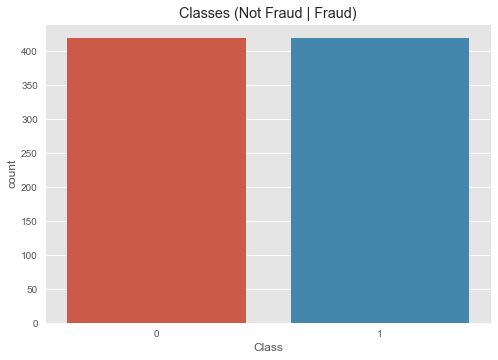

Undersampled model shape: (838, 31)


In [148]:
plt.title('Classes (Not Fraud | Fraud)')
sns.countplot(x = 'Class', data = undersampled_df)
plt.show()
print(f'Undersampled model shape: {undersampled_df.shape}')

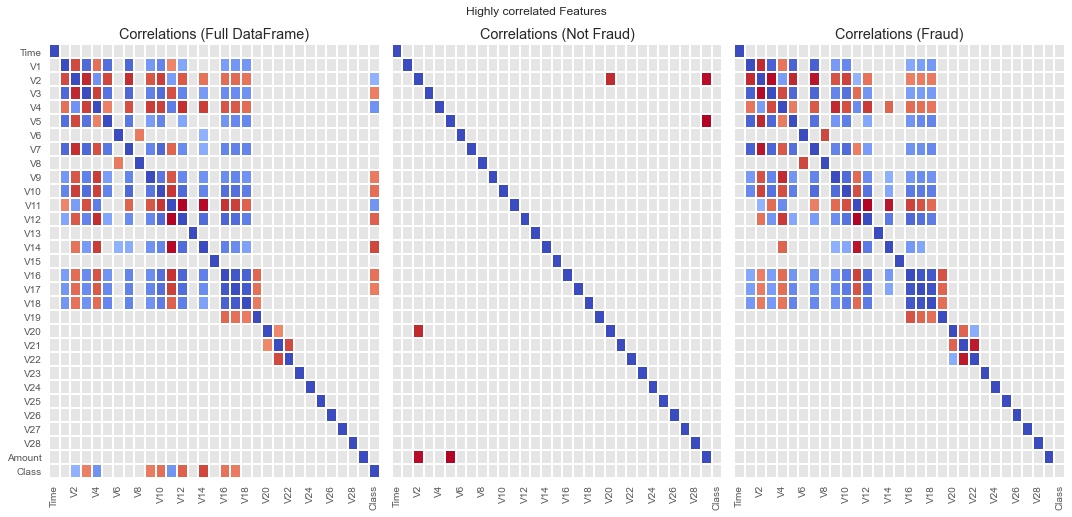

In [149]:
corr_plot_info(undersampled_df)

In [150]:
us_corr = corr_plot_info(undersampled_df, plot = False)[0]['Class'].dropna().sort_values(ascending = False)
corr_features = us_corr.to_frame().T.drop(columns = 'Class').style.format("{:.2f}")
corr_cols = corr_features.data.columns
corr_cols_abs = corr_features.data.T.apply(abs).sort_values(by = 'Class', ascending = False).index
corr_features

,V4,V11,V2,V3,V9,V17,V16,V10,V12,V14
Class,0.68,0.67,0.52,-0.54,-0.55,-0.55,-0.59,-0.60,-0.66,-0.75


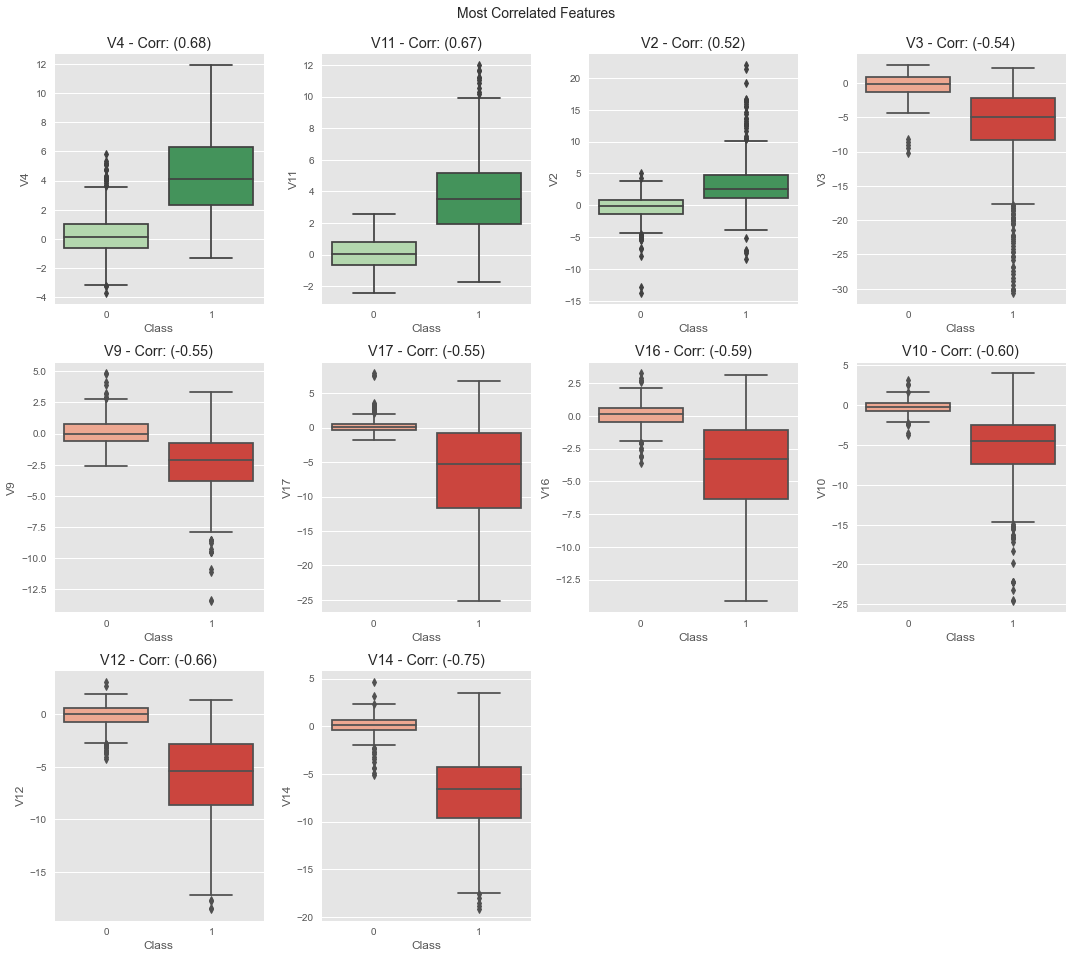

In [151]:
n_rows = 3
n_cols = round((len(corr_cols)+0.1*n_rows)/n_rows)+1
plt.figure(figsize = (15,13))
plt.suptitle(y = 1.02, t = 'Most Correlated Features', fontsize = 14)
for n,col in enumerate(corr_cols):
    corr_val = float(corr_features.data[col].values)
    cmap = 'Greens'
    if corr_val < 0:
        cmap = 'Reds'
    plt.subplot(n_rows,n_cols,n+1)
    plt.title(f'{col} - Corr: ({corr_val:.2f})')
    sns.boxplot(x = 'Class', y = col, data = undersampled_df, palette = cmap)
plt.tight_layout()
plt.show()

In [152]:
out_c = 3
indices_to_drop = []

for col in corr_cols:
    
    out_dict = undersampled_df.loc[tukey_fences(undersampled_df[col], k = out_c, verbose = False)]['Class'].value_counts().to_dict()
    
    print(f'{col} ({float(corr_features.data[col].values):.2f})', end = '\t')
    print(f"{out_dict}", end = '\t- ')
    indices_to_drop.extend(tukey_fences(undersampled_df[col], k = out_c))

indices_to_drop = set(indices_to_drop)
print(f'\nTotal indices to drop: {len(indices_to_drop)}')

V4 (0.68)	{}	- Ext. Outliers outside of range: [-12.67, 17.05] | Total Ext. Outliers: 0
V11 (0.67)	{}	- Ext. Outliers outside of range: [-10.99, 14.42] | Total Ext. Outliers: 0
V2 (0.52)	{1: 26, 0: 2}	- Ext. Outliers outside of range: [-9.84, 12.14] | Total Ext. Outliers: 28
V3 (-0.54)	{1: 27}	- Ext. Outliers outside of range: [-20.86, 15.98] | Total Ext. Outliers: 27
V9 (-0.55)	{1: 4}	- Ext. Outliers outside of range: [-10.10, 8.08] | Total Ext. Outliers: 4
V17 (-0.55)	{1: 6}	- Ext. Outliers outside of range: [-22.31, 17.55] | Total Ext. Outliers: 6
V16 (-0.59)	{}	- Ext. Outliers outside of range: [-14.31, 11.38] | Total Ext. Outliers: 0
V10 (-0.60)	{1: 9}	- Ext. Outliers outside of range: [-17.80, 13.15] | Total Ext. Outliers: 9
V12 (-0.66)	{}	- Ext. Outliers outside of range: [-22.05, 16.72] | Total Ext. Outliers: 0
V14 (-0.75)	{}	- Ext. Outliers outside of range: [-26.93, 20.54] | Total Ext. Outliers: 0

Total indices to drop: 43


`V4` and `V14` are the most correlated variables with the classes and have no extreme outliers. Most outliers appear around ~`0.50` correlation
- For now at least we will not remove any outlier
- Most correlated variables do not have any extreme outliers

In [153]:
(undersampled_df.Class == 1).value_counts()

True     419
False    419
Name: Class, dtype: int64

### Model analysis

- As we have balanced the labels we can observe the performance of the initial models and perform validation using metrics such as roc_auc or accuracy but the final testing which is performed upon a chunk of unseen unbalanced data (maintaining the same ratio of unbalanced data as the original) will be evaluated using F1
- We will focus only in one evaluation metric at the time as it is easier to compare between models. Using multiple metrics at the same time may produce confusion halting the model selection process

### Undersampled data

In [154]:
X = undersampled_df.drop(columns = ['Class'])
y = undersampled_df['Class']

In [155]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

I Use just 3 splits instead of the classic 5 ot 10 splits due to the shortage of data in this problem and fewer folds may produce more relevant results as it tests and train in more data for each fold

In [156]:
inside_cv = StratifiedKFold(n_splits = 3, random_state = in_folds, shuffle = True)
outside_cv = StratifiedKFold(n_splits = 3, random_state = out_folds, shuffle = True)

In [157]:
models = {
    'logreg': LogisticRegression(solver = 'lbfgs', n_jobs = 4),
    'knn': KNeighborsClassifier(),
    'nbayes': GaussianNB(),
    'svc': SVC(gamma = 'scale'),
    'xgb': xgb.XGBClassifier(num_threads = 4),
    'lgb': lgb.LGBMClassifier(num_threads = 4)
}

As the labels are now balanced we can use scoring metrics such as `accuracy` or `roc_auc`

In [158]:
model_scores = {}
for model in models:
    scores = cross_val_score(models[model], X, y, scoring = 'f1', cv = outside_cv)
    model_scores[model] = {'scores': scores,'mean_score': np.mean(scores)}
    print(f"{model}",f"\t| mean score: {model_scores[model]['mean_score']:.2f}")

logreg 	| mean score: 0.92
knn 	| mean score: 0.89
nbayes 	| mean score: 0.89
svc 	| mean score: 0.91
xgb 	| mean score: 0.92
lgb 	| mean score: 0.92


In [162]:
warnings.filterwarnings('ignore')

lr = [(0.1/10**i) for i in range(4)]
C = [(100/10**i) for i in range(6)]
reg = np.linspace(0,2,9)

params = {
    'logreg':{
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'fit_intercept': [True, False],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'C': C
            },
    'knn':{
            'n_neighbors' : [i for i in range(2,11)],
            'algorithm' : ['ball_tree'], #'kd_tree', 'brute'
            'p': np.linspace(1, 2, 2)
            },
    'svc':{
            'C' : C,
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            },
    'xgb':{
            'n_estimators' : [i*25 for i in range(4, 7)],
            'learning_rate': lr,
            'booster' : ['gbtree'],
            'reg_alpha' : reg,
            'reg_lambda' : reg
            },
    'lgb':{
            'n_estimators' : [i*25 for i in range(4, 7)],
            'boosting_type': ['gbdt'],
            'learning_rate': lr,
            'reg_alpha': reg,
            'reg_lambda': reg
            }
}

tunned_params = model_tunner(models, X, y, params, 'f1', inside_cv)

Total iterations (logreg): 720
	logreg	| Best score: 0.93 - {'C': 100.0, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Total iterations (knn): 54
	knn	| Best score: 0.91 - {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 1.0}
Total iterations (svc): 72
	svc	| Best score: 0.93 - {'C': 10.0, 'kernel': 'linear'}
Total iterations (xgb): 2916
	xgb	| Best score: 0.94 - {'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 125, 'reg_alpha': 1.0, 'reg_lambda': 0.25}
Total iterations (lgb): 2916
	lgb	| Best score: 0.94 - {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0.25, 'reg_lambda': 0.0}


In [163]:
tune_models(models, tunned_params)

In [164]:
X_test = scaler.transform(test_set.drop(columns = 'Class'))
y_test = test_set.Class

scoring = f1_score
for model in models:
    models[model].fit(X,y)
    y_pred = models[model].predict(X_test)
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                          index = ['Real - Not_Fraud', 'Real - Fraud'], 
                                          columns = ['Pred - Not_Fraud', 'Pred - Fraud'])
    
    results = f"Model: {model} - Score: {scoring(y_test,y_pred):.2f}\n" +\
              '-'*50 + f"\n{conf_matrix}\n" +'-'*50
    print(results)

Model: logreg - Score: 0.11
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             41565          1082
Real - Fraud                     5            68
--------------------------------------------------
Model: knn - Score: 0.09
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             41253          1394
Real - Fraud                     5            68
--------------------------------------------------
Model: nbayes - Score: 0.13
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             41769           878
Real - Fraud                     8            65
--------------------------------------------------
Model: svc - Score: 0.16
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             41934           71

First we've tried solving the problem by undersampling. This has proven to be ineffective. 
- The model seems to correctly classify most of the Frauds but the number of non-frauds incorrectly classified is too high to be a viable solution as it will interrupt the normal operational continuity of the bank probably causing bigger losses and discontent within the customers
- This database corresponds to just two days of transactions (`~500` wrongly classified transactions per day) which translates to `~15.000`incorrectly classified transactions per month (About `0.35%` of the non-fraud transactions)
- As we undersampled we managed to generate a balanced dataset but at the cost of losing valuable `NON-FRAUD` data

### Oversampled Data

To oversample we will use SMOTE. SMOTE will create as much data as we need in order to balance the data.
- SMOTE works by applying knn to the available data points in the class to generate extra fields
- We start by using only a slice of all the data for a faster execution 

In [165]:
nr.seed(SEED)
not_fraud_sample = not_fraud_train.sample(n = len(not_fraud_train)//20) #//20

over_temp_df = pd.concat([not_fraud_sample, fraud_train], axis = 0)

X_over_temp = over_temp_df.drop('Class', axis = 1)
y_over = over_temp_df.Class

X_over_temp_scaled = scaler.transform(X_over_temp)


sm = SMOTE(sampling_strategy = 'minority',
           k_neighbors = 5)

X_over, y_over = sm.fit_resample(X_over_temp_scaled, y_over)

Xy_over = np.c_[X_over, y_over]
nr.seed(SEED)
nr.shuffle(Xy_over)

X_over = Xy_over[:,:-1]
y_over = Xy_over[:,-1]

- Lets test the oversampled data over the already undersampled tunned models

In [166]:
model_scores = {}
for model in models:
    scores = cross_val_score(models[model], X_over, y_over, scoring = 'f1', cv = outside_cv)
    model_scores[model] = {'scores': scores,'mean_score': np.mean(scores)}
    print(f"{model}",f"\t| mean score: {model_scores[model]['mean_score']:.2f}")

logreg 	| mean score: 0.95
knn 	| mean score: 0.99
nbayes 	| mean score: 0.90
svc 	| mean score: 0.95
xgb 	| mean score: 0.98
lgb 	| mean score: 1.00


In [167]:
tunned_params = model_tunner(models, X_over, y_over, params, 'f1', inside_cv)

Total iterations (logreg): 720
	logreg	| Best score: 0.95 - {'C': 100.0, 'fit_intercept': True, 'penalty': 'none', 'solver': 'newton-cg'}
Total iterations (knn): 54
	knn	| Best score: 0.99 - {'algorithm': 'ball_tree', 'n_neighbors': 2, 'p': 1.0}
Total iterations (svc): 72
	svc	| Best score: 0.99 - {'C': 100.0, 'kernel': 'rbf'}
Total iterations (xgb): 2916
	xgb	| Best score: 0.99 - {'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 150, 'reg_alpha': 0.75, 'reg_lambda': 0.5}
Total iterations (lgb): 2916
	lgb	| Best score: 1.00 - {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 150, 'reg_alpha': 0.0, 'reg_lambda': 0.0}


In [168]:
tune_models(models, tunned_params)

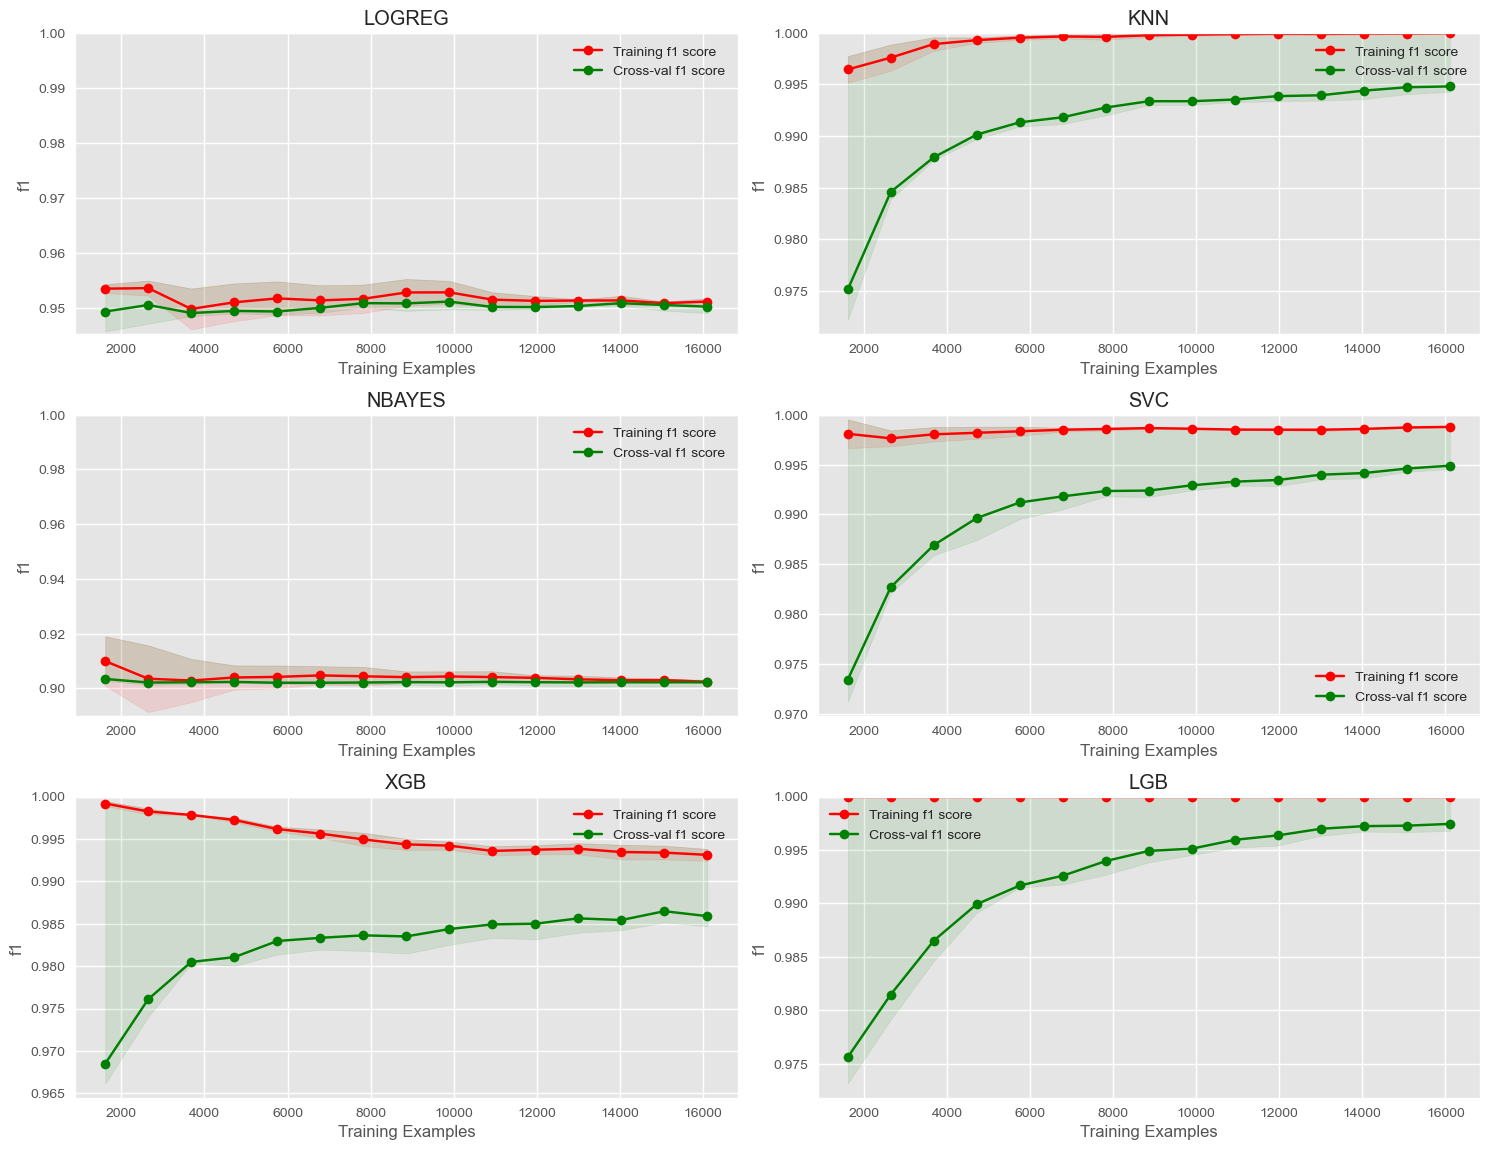

In [193]:
plt.figure(figsize = (15,15), dpi = 100)
plot_learning_curve(models = models, 
                    X = X_over,
                    y = y_over, 
                    cv = outside_cv, 
                    score = 'f1',
                    ylim = (None, 1.),
                    train_sizes = np.linspace(.1, 1.0, 15))
plt.show()

- Some models at the beginning look quite overfitted, but in the end, as more training samples are added, the difference between test and train diminishes achieving great results with the models being able to generalize.
- `logreg` and `nbayes` did not improve in performance as more samples where added.
- The rest of the models quickly overfitted and `xgb` started pretty overfit and regulated itself a bit.
- The best performing model still is `lgb`. So further improvements will be applied to this model

In [170]:
scoring = f1_score
for model in models:
    models[model].fit(X_over,y_over)
    y_pred = models[model].predict(X_test)
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                          index = ['Real - Not_Fraud', 'Real - Fraud'], 
                                          columns = ['Pred - Not_Fraud', 'Pred - Fraud'])
    
    results = f"Model: {model} - Score: {scoring(y_test,y_pred):.2f}\n" +\
              '-'*50 + f"\n{conf_matrix}\n" +'-'*50
    print(results)

Model: logreg - Score: 0.13
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             41761           886
Real - Fraud                     5            68
--------------------------------------------------
Model: knn - Score: 0.29
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             42348           299
Real - Fraud                     9            64
--------------------------------------------------
Model: nbayes - Score: 0.11
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             41581          1066
Real - Fraud                     8            65
--------------------------------------------------
Model: svc - Score: 0.29
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             42406           24

- In contrast with undersampling, we can see that Fraud detection suffers a bit, but not much in most of the models (Even thou we oversampled the data by an absurd amount.
- KNN shows great scores overall
- SVC scores greatly in `f1` but `recall` suffers quite a lot.
- Not-fraud identification improves drastically. This is specially noticable in `lgb` model whose performance in fraud detection goes down a bit, but non-fraud identification only misclassifies `~100`.

Thus we will proceed with this model `lgb`

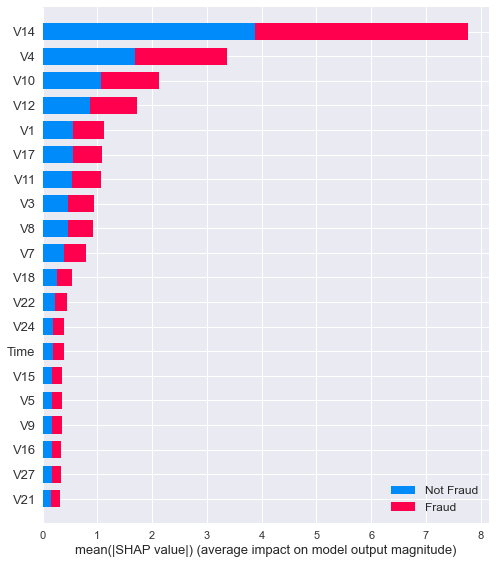

In [171]:
plt.style.use('seaborn')
explainer = shap.TreeExplainer(models['lgb'])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, 
                  class_names= ['Not Fraud', 'Fraud'],
                  feature_names=X_over_temp.columns, 
                  plot_type = 'bar')

- Most correlated variables such as `V14` and `V4` seem to be the most important variables in `lgb` for the prediction

Lets train the model with all the data

In [188]:
not_fraud_all = not_fraud_train.sample(n = len(not_fraud_train))
over_all_df = pd.concat([not_fraud_all, fraud_train], axis = 0)
X_over_all = over_all_df.drop('Class', axis = 1)
y_over_all = over_all_df.Class
X_over_all_scaled = scaler.transform(X_over_all)
nr.seed(SEED)
X_over_all, y_over_all = sm.fit_resample(X_over_all_scaled, y_over_all)

In [189]:
models['lgb'].fit(X_over_all,y_over_all)
y_pred = models['lgb'].predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                          index = ['Real - Not_Fraud', 'Real - Fraud'], 
                                          columns = ['Pred - Not_Fraud', 'Pred - Fraud'])
    
results = f"Model: {model} - Score: {scoring(y_test,y_pred):.2f}\n" +\
              '-'*50 + f"\n{conf_matrix}\n" +'-'*50

In [190]:
print(results)
print(f'Recall: {recall_score(y_test, y_pred):.2f}\nPrecision: {precision_score(y_test, y_pred):.2f}')

Model: lgb - Score: 0.82
--------------------------------------------------
                  Pred - Not_Fraud  Pred - Fraud
Real - Not_Fraud             42627            20
Real - Fraud                     8            65
--------------------------------------------------
Recall: 0.89
Precision: 0.76


- Performance suffers a bit in `FRAUD` detection but `NON-FRAUD` detection.
- In order to improve performance we may add more data (Current model only uses 2 days worth of data), clean some outliers, generate meta-features or play a bit more with the parameters (increase regularization, for example).

In The end, the resulting model will have to make sacrifices either by letting some `FRAUDS` go by or by incurring into more `False-Positives`. The final selection should determined by some business tolerance metric which determines the amount of missclasifications allowed to guarantee operational continuity

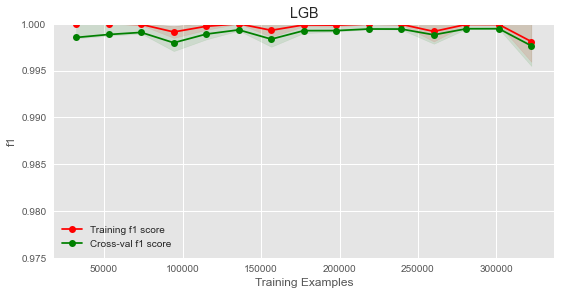

In [197]:
plt.figure(figsize = (15,15))
plot_learning_curve(models = models, 
                    X = X_over_all,
                    y = y_over_all, 
                    cv = outside_cv, 
                    score = 'f1',
                    ylim = (0.975, 1.),
                    train_sizes = np.linspace(.1, 1.0, 15),
                    skip_models = [x for x in models.keys() if x != 'lgb'])
plt.show()

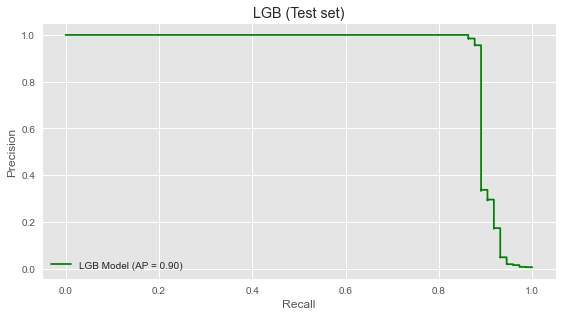

In [248]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (9.2, 4.7))
plot_precision_recall_curve(models['lgb'],
                            X = X_test,
                            y = y_test, 
                            name='LGB Model', color = 'green', ax = ax)
ax.set_title('LGB (Test set)')
plt.show()